# Mapas Covid

In [20]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
import zipfile
from tensorflow.keras.utils import get_file
style.use('default')

In [25]:
plt.rcParams['backend'] = 'SVG'

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [3]:
fZipName = 'HIST_PAINEL_COVIDBR_02nov2020'
zf = zipfile.ZipFile('../data/' + fZipName + '.zip') 
df = pd.read_csv(zf.open( fZipName + '.csv'), sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242668 entries, 0 to 1242667
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   regiao                  1242668 non-null  object 
 1   estado                  1242415 non-null  object 
 2   municipio               1230970 non-null  object 
 3   coduf                   1242668 non-null  int64  
 4   codmun                  1235611 non-null  float64
 5   codRegiaoSaude          1230970 non-null  float64
 6   nomeRegiaoSaude         1230970 non-null  object 
 7   data                    1242668 non-null  object 
 8   semanaEpi               1242668 non-null  int64  
 9   populacaoTCU2019        1238027 non-null  float64
 10  casosAcumulado          1242668 non-null  int64  
 11  casosNovos              1242668 non-null  int64  
 12  obitosAcumulado         1242668 non-null  int64  
 13  obitosNovos             1242668 non-null  int64  
 14  Re

### Dias de semana como varíável categórica 

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['data'] = pd.to_datetime(df['data'],format="%Y-%m-%d")
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [5]:
uf = 'Ba'
Muni = 'Jequié'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def preproc_filter_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [7]:
df_est, df_est_sem, df_cidade, df_cidade_sem = preproc_filter_df(df, uf, Muni)

In [8]:

def casos_acumulados(df_muni, muni, pathfigs = './figs/'):
    df_muni.sort_values('data', inplace = True)
    df_muni['ca_log'] = df_muni['casosAcumulado'].apply(lambda x: np.log10(x))
    dia_0 = df_muni['data'].min()
    df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{}: \n Casos Acumulados por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'casosAcumulado', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
##### figura 01 -casos acumulados por dia(log)
    plt.figure(2, figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados por Dia(log)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'ca_log', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_log10_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(2)
    print ('dia zero', dia_0)
    print('Casos Novos\n',df_muni.loc[:,['casosNovos', 'data']].tail(14))
    print('Casos Totais\n', df_muni['casosAcumulado'].max())
    

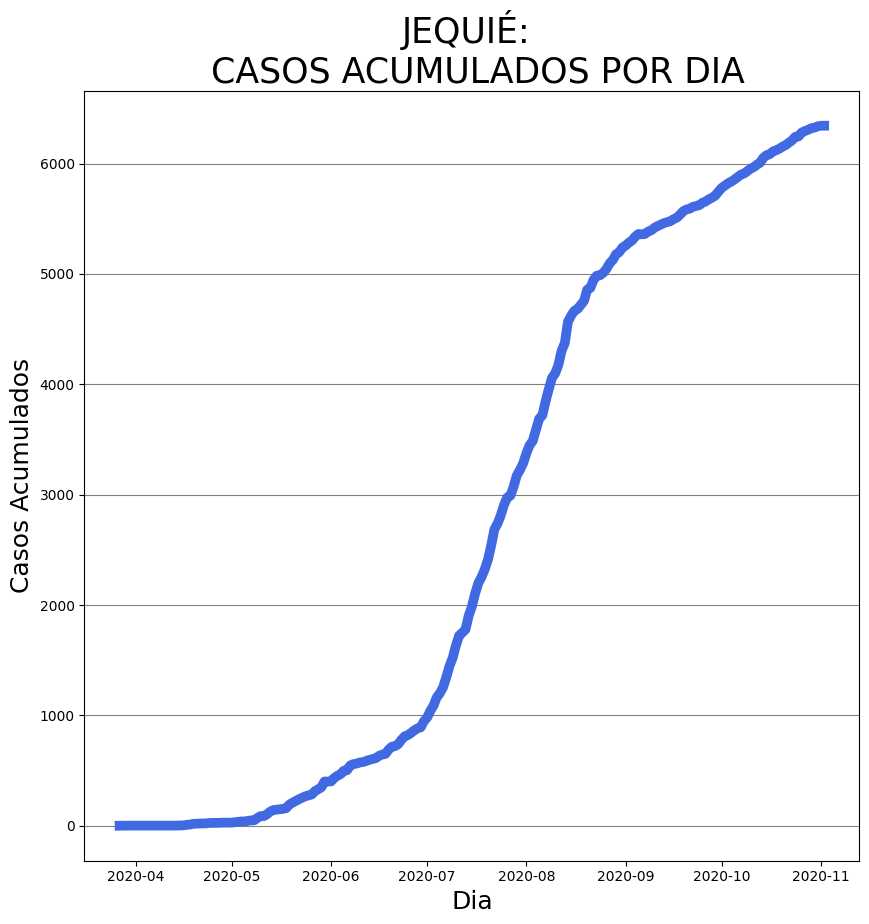

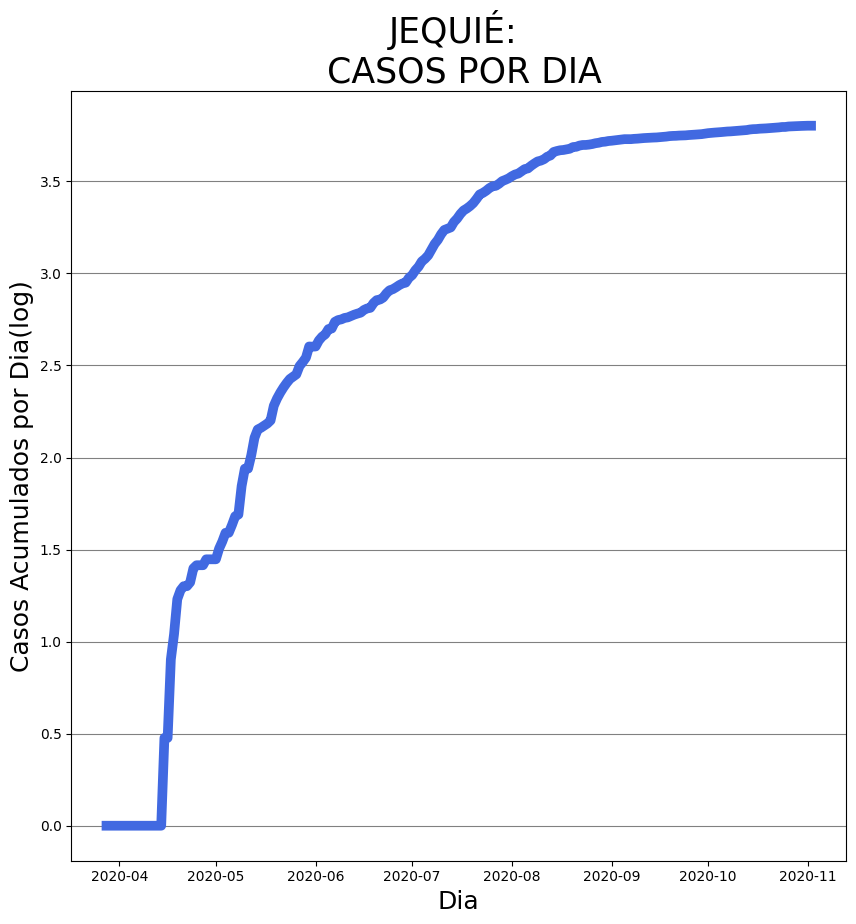

dia zero 2020-03-27 00:00:00
Casos Novos
         casosNovos       data
460535          18 2020-10-20
460536          15 2020-10-21
460537          22 2020-10-22
460538          21 2020-10-23
460539          32 2020-10-24
460540           3 2020-10-25
460541          36 2020-10-26
460542          13 2020-10-27
460543          11 2020-10-28
460544          15 2020-10-29
460545           5 2020-10-30
460546          12 2020-10-31
460547           5 2020-11-01
460548           0 2020-11-02
Casos Totais
 6343


In [9]:
casos_acumulados(df_cidade, Muni)

### Função Grafico de casos por dia

In [10]:
def casos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    print('Casos Totais\n', df1['casosAcumulado'].max())

    fig = plt.figure(1, figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='casosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    
    plt.title('{}: \n Casos por Semana Epidemiológica por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=20)
    plt.ylabel('Número de Casos', fontsize=20)
    plt.grid(axis='y', color='grey')
    plt.rcParams['legend.title_fontsize'] = 18

    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_casos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)

Casos Totais
 6343


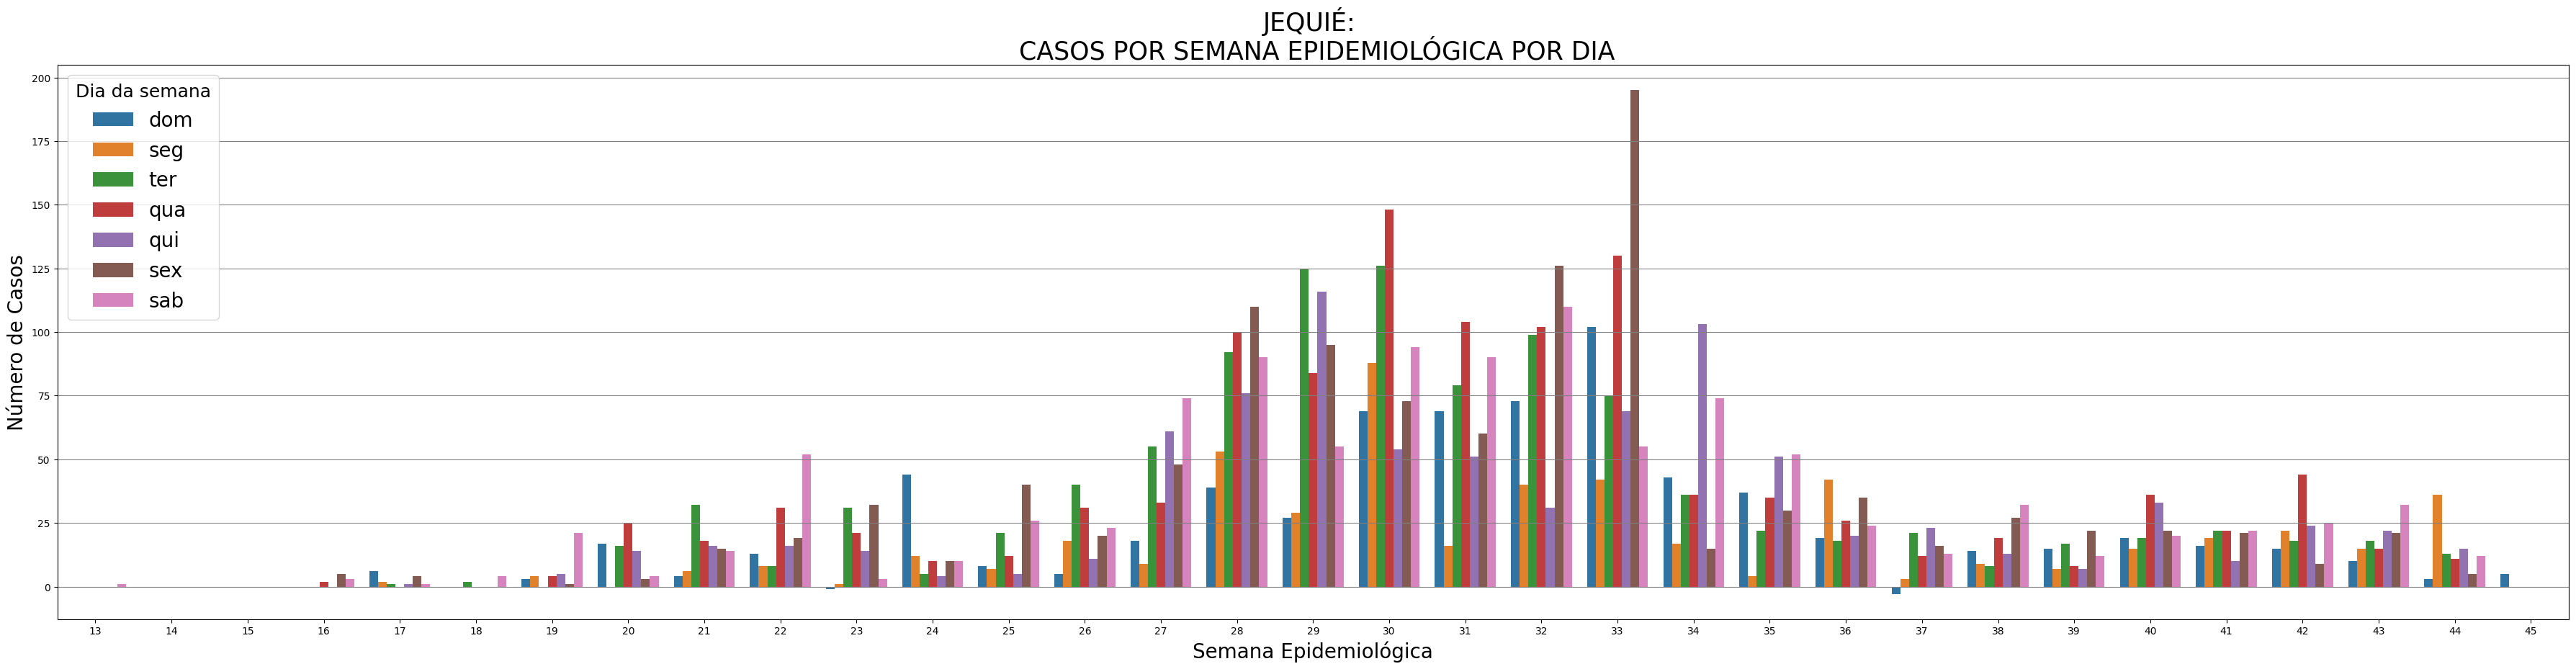

In [11]:
casos_dia_local(df_cidade, Muni)

### Casos por dia (média móvel de 7 dias)

In [12]:
def casos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ###- tratando números negativos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])

    df1['media_movel_casos'] =df1.rolling(7, center=False)['casosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia (média móvel de 7 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos (média móvel de 7 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_casos', data=df1, color= 'teal', width=.8)
    plt.savefig( pathfigs + local + '_dia_casos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_casos', 'data']].head(14))
    print(df1.loc[:,['media_movel_casos', 'data']].tail(14))

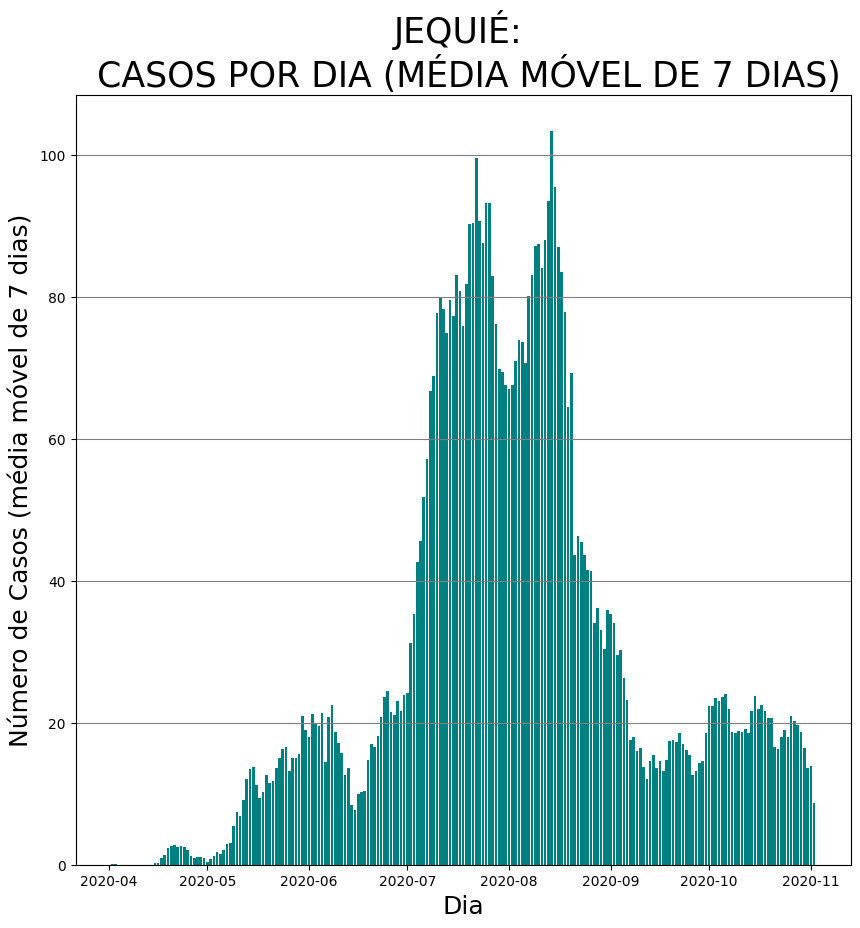

Média móvel por dia
         media_movel_casos       data
460328                NaN 2020-03-27
460329                NaN 2020-03-28
460330                NaN 2020-03-29
460331                NaN 2020-03-30
460332                NaN 2020-03-31
460333                NaN 2020-04-01
460334           0.142857 2020-04-02
460335           0.142857 2020-04-03
460336           0.000000 2020-04-04
460337           0.000000 2020-04-05
460338           0.000000 2020-04-06
460339           0.000000 2020-04-07
460340           0.000000 2020-04-08
460341           0.000000 2020-04-09
        media_movel_casos       data
460535          20.714286 2020-10-20
460536          16.571429 2020-10-21
460537          16.285714 2020-10-22
460538          18.000000 2020-10-23
460539          19.000000 2020-10-24
460540          18.000000 2020-10-25
460541          21.000000 2020-10-26
460542          20.285714 2020-10-27
460543          19.714286 2020-10-28
460544          18.714286 2020-10-29
460545          1

In [13]:
casos_dia_media_movel(df_cidade, Muni)

In [14]:
def obitos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ### valores negativos de novos obitos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    
    print('Óbitos por dia\n',df1.loc[:,['obitosNovos', 'data']].tail(14))
    print('Óbitos Totais\n', df1['obitosAcumulado'].max())

    fig =  plt.figure(1,figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='obitosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    plt.title('{}: \n Óbitos por Semana Epidemiológica por dia da semana'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_obitos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
    


Óbitos por dia
         obitosNovos       data
460535            0 2020-10-20
460536            2 2020-10-21
460537            0 2020-10-22
460538            0 2020-10-23
460539            0 2020-10-24
460540            1 2020-10-25
460541            0 2020-10-26
460542            0 2020-10-27
460543            0 2020-10-28
460544            0 2020-10-29
460545            0 2020-10-30
460546            0 2020-10-31
460547            1 2020-11-01
460548            0 2020-11-02
Óbitos Totais
 151


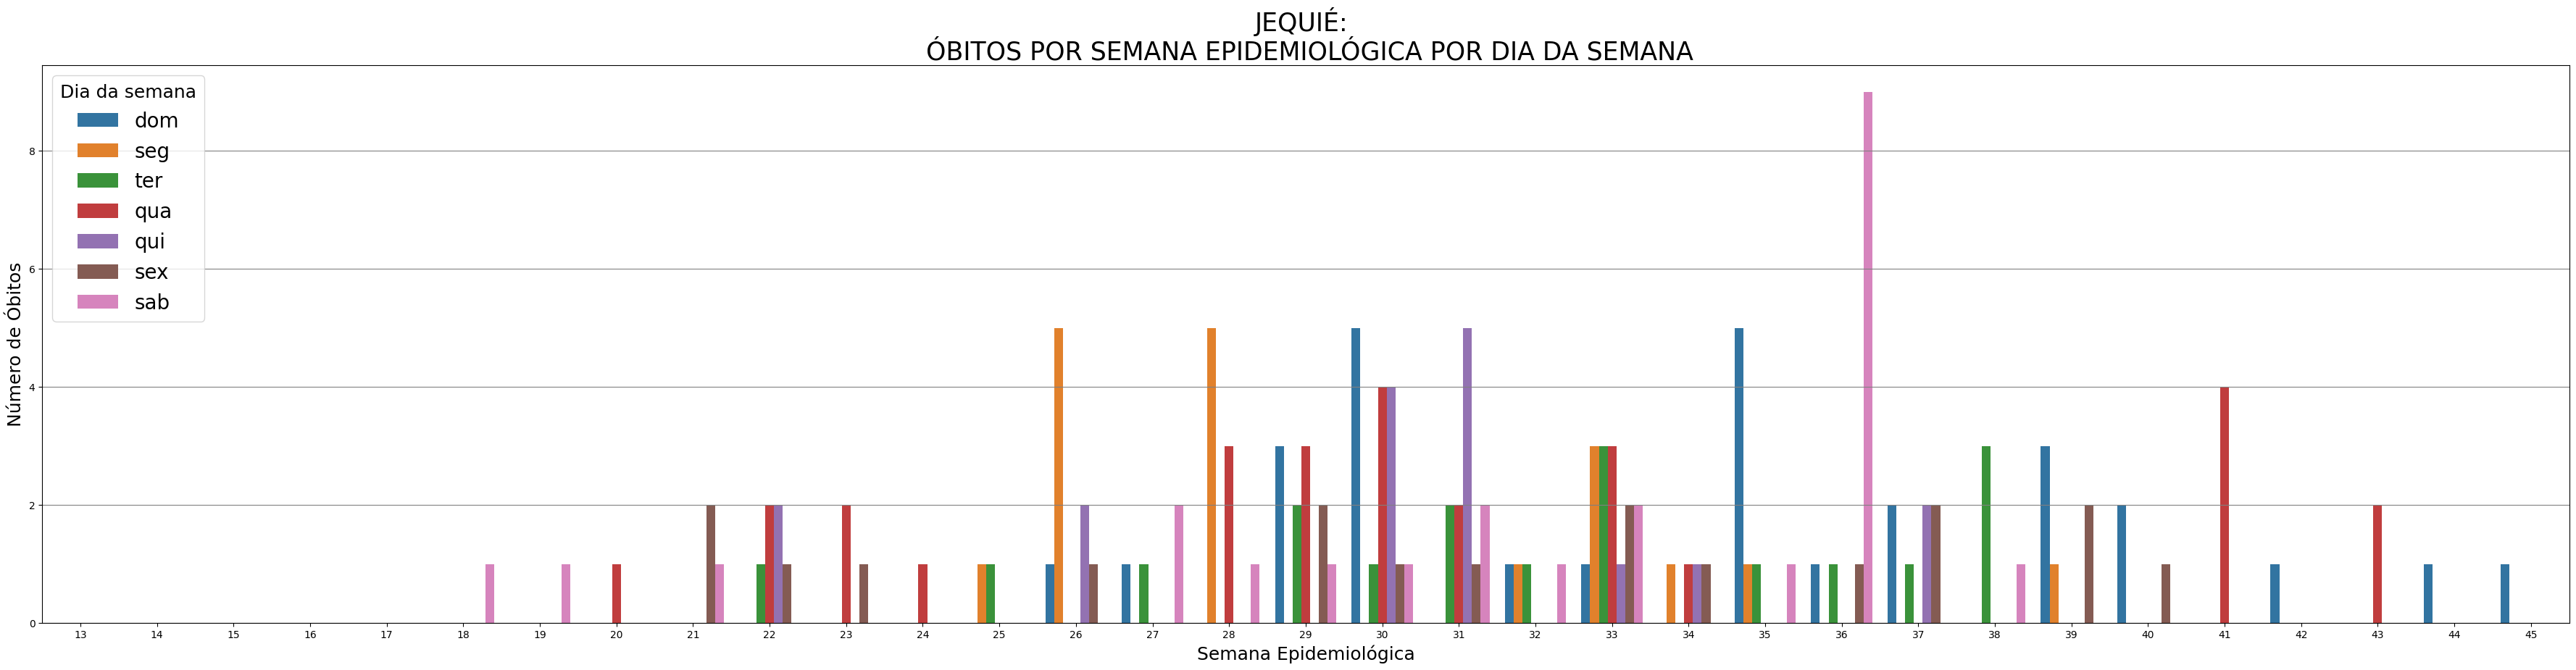

In [15]:
obitos_dia_local(df_cidade, Muni)

### Obitos por dia (média movel de 7 dias)

In [16]:
def obitos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    df1['media_movel_obitos'] =df1.rolling(7, center=False)['obitosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia (média móvel de 7 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos (média móvel de 7 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_obitos', data=df1, color= 'saddlebrown', width=.8)
    plt.savefig( pathfigs + local + '_dia_obitos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_obitos', 'data']].head(14))
    print(df1.loc[:,['media_movel_obitos', 'data']].tail(14))

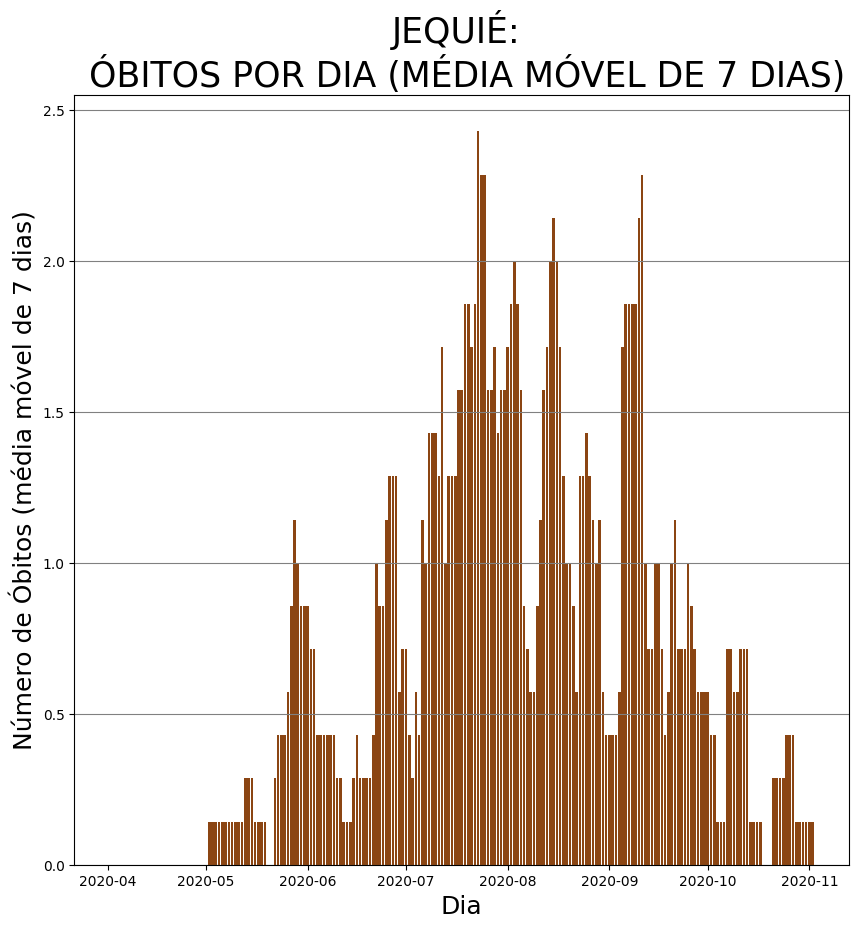

Média móvel por dia
         media_movel_obitos       data
460328                 NaN 2020-03-27
460329                 NaN 2020-03-28
460330                 NaN 2020-03-29
460331                 NaN 2020-03-30
460332                 NaN 2020-03-31
460333                 NaN 2020-04-01
460334                 0.0 2020-04-02
460335                 0.0 2020-04-03
460336                 0.0 2020-04-04
460337                 0.0 2020-04-05
460338                 0.0 2020-04-06
460339                 0.0 2020-04-07
460340                 0.0 2020-04-08
460341                 0.0 2020-04-09
        media_movel_obitos       data
460535            0.000000 2020-10-20
460536            0.285714 2020-10-21
460537            0.285714 2020-10-22
460538            0.285714 2020-10-23
460539            0.285714 2020-10-24
460540            0.428571 2020-10-25
460541            0.428571 2020-10-26
460542            0.428571 2020-10-27
460543            0.142857 2020-10-28
460544            0.142857 20

In [17]:
obitos_dia_media_movel(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [18]:
def casos_semana_local(df, local, pathfigs = './figs/'):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( pathfigs + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print('Casos por semana epidemiológica\n',df.loc[:,['semanaEpi','casosNovos']])

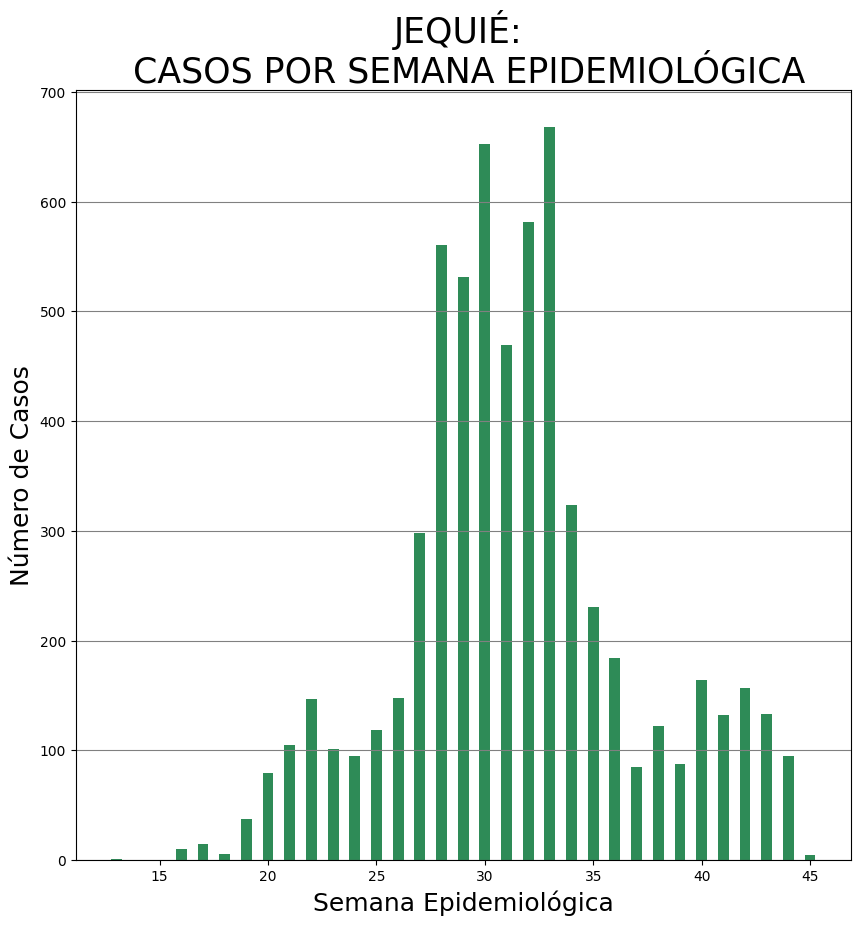

Casos por semana epidemiológica
     semanaEpi  casosNovos
0          13           1
1          14           0
2          15           0
3          16          10
4          17          15
5          18           6
6          19          38
7          20          79
8          21         105
9          22         147
10         23         101
11         24          95
12         25         119
13         26         148
14         27         298
15         28         560
16         29         531
17         30         652
18         31         469
19         32         581
20         33         668
21         34         324
22         35         231
23         36         184
24         37          85
25         38         122
26         39          88
27         40         164
28         41         132
29         42         157
30         43         133
31         44          95
32         45           5


In [19]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [21]:
def obitos_semana_local(df, local, pathfigs = './figs/'):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( pathfigs + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')


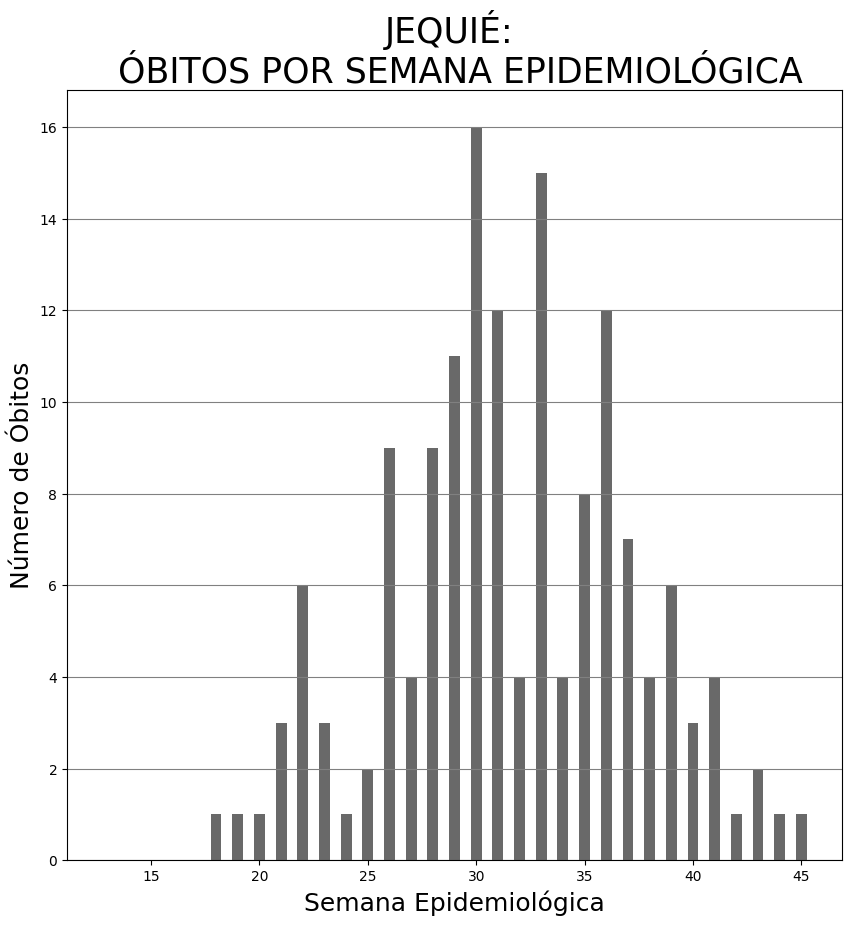

In [22]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [23]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\GitRepos\graficos_covid\bahia_acompanhamento


'd:\\GitRepos\\graficos_covid\\bahia_acompanhamento\\geojsonDL\\BA.json'

### Carregando arquivo GeoJson do estado

In [24]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [26]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid-19 -- {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

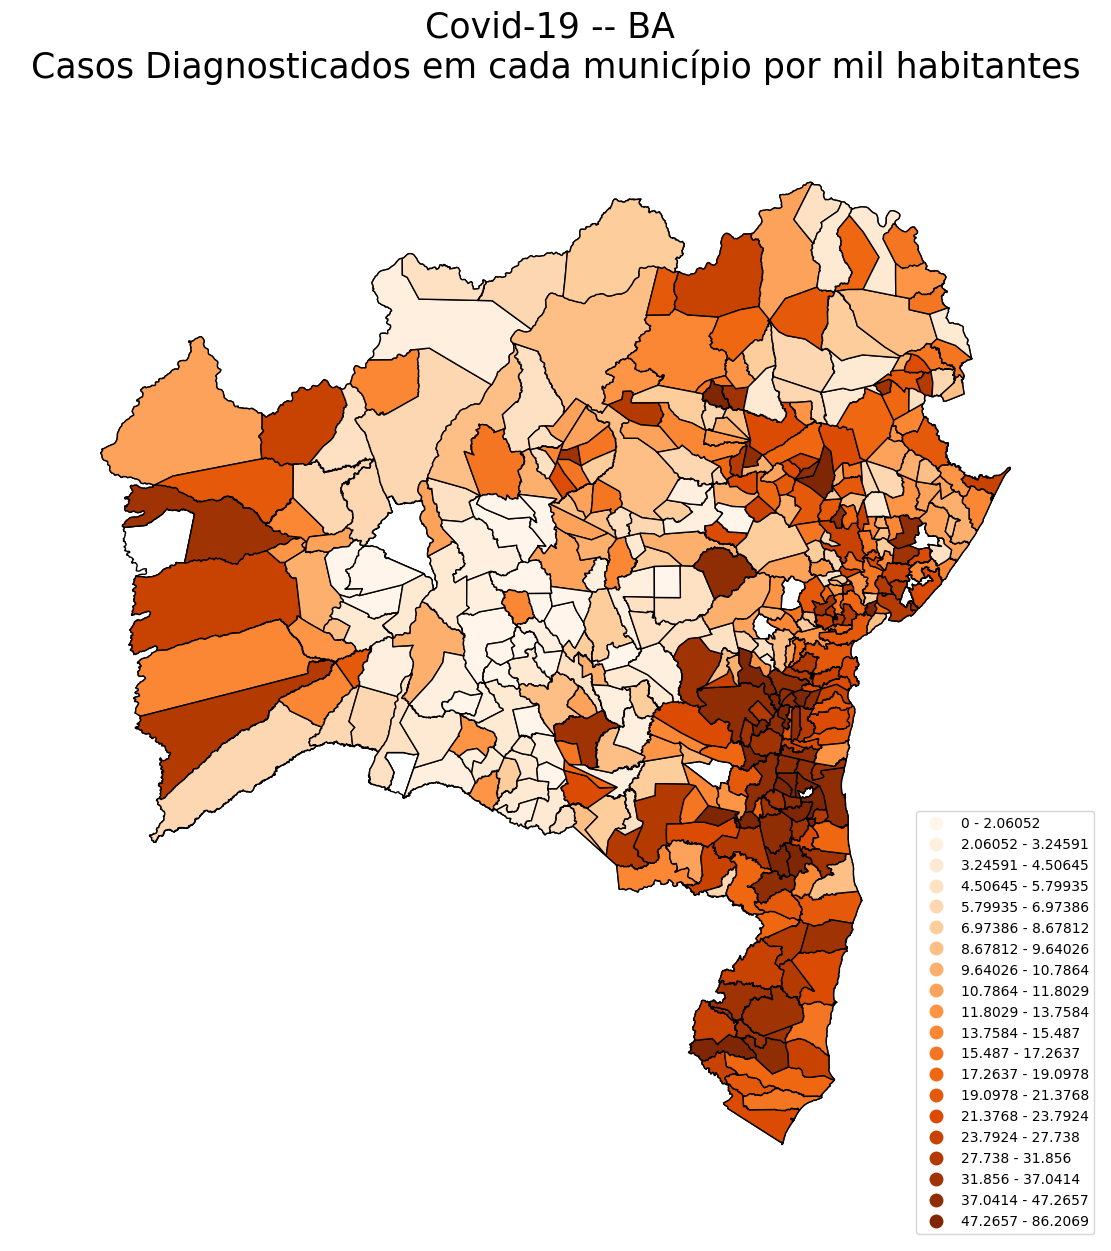

In [27]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

In [28]:
def mapa_obitos_estado(df, df_geo, uf, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid-19 -- {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


In [ ]:
mapa_obitos_estado(df_est, mapa, uf, 20)